In [39]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

freeze = False
dropout = True
prob = 0.3
lr = 0.001
momentum = 0.9
step_size = 20
gamma = 0.1
criterion_name = 'Focal'
optimizer_name = 'Adam'
num_classes = 2
num_epochs = 30
batch_size = 30

In [40]:
transform = v2.Compose([
    v2.Resize(256),   #must same as here
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

train_data = datasets.ImageFolder(root=f"/kaggle/input/covid19-xray-two-proposed-databases/Datasets/5-classes/Train", transform=transform)
val_data = datasets.ImageFolder(root=f"/kaggle/input/covid19-xray-two-proposed-databases/Datasets/5-classes/Val", transform=transform)
test_data = datasets.ImageFolder(root=f"/kaggle/input/covid19-xray-two-proposed-databases/Datasets/5-classes/Test", transform=transform)


train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [41]:
print('Train dataset size:', train_size)
print('Validate dataset size:', val_size)
print('Test dataset size:', test_size)
class_names = train_data.classes
print('Class names:', class_names)

Train dataset size: 2020
Validate dataset size: 500
Test dataset size: 1035
Class names: ['Bacterial', 'Covid-19', 'Lung Opacity', 'Normal', 'Viral']


labels tensor([1, 3, 4, 0, 0, 3, 0, 1, 0, 1, 3, 2])


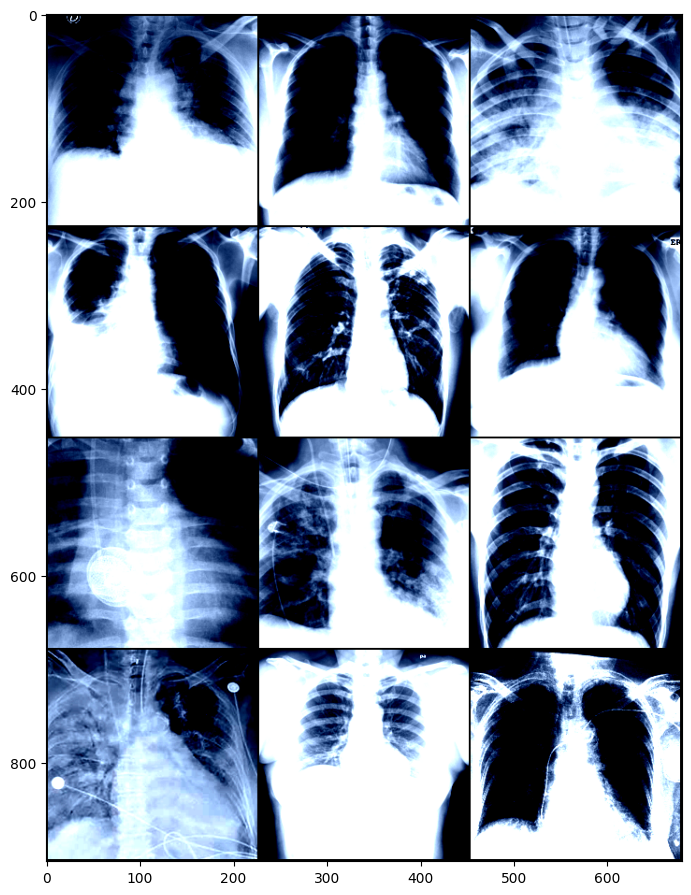

In [42]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 12,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch

    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels',labels)

show_transformed_images(train_data)

In [45]:
model = models.resnet18(weights=None,num_classes=20)
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [46]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
features = []
labels = []
with torch.no_grad():
    for images, batch_labels in test_loader:
        batch_features = feature_extractor(images)
        batch_features = torch.flatten(batch_features, start_dim=1)
        features.append(batch_features)
        labels.append(batch_labels)
features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

In [62]:
distances = pairwise_distances(features.numpy())
sigma = torch.median(torch.tensor(distances)).item()
similarities = torch.exp(-torch.tensor(distances)**2 / (2 * sigma**2))

# Compute t-SNE embeddings
tsne = TSNE(n_components=3, perplexity=30, verbose=1)
embeddings = tsne.fit_transform(similarities.numpy())


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1035 samples in 0.001s...
[t-SNE] Computed neighbors for 1035 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1035
[t-SNE] Computed conditional probabilities for sample 1035 / 1035
[t-SNE] Mean sigma: 0.750202
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.044060
[t-SNE] KL divergence after 1000 iterations: 0.270199


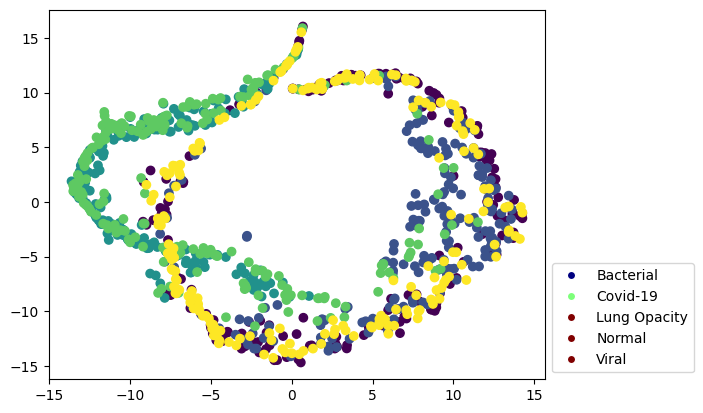

In [63]:
# Plot the embeddings with legend
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels.numpy())

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=class_name, 
                               markerfacecolor=plt.cm.jet(i/num_classes)) for i, class_name in enumerate(class_names)]
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0))

plt.show()
